In [1]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2

import tensorflow as tf
import keras
import keras_cv
from tensorflow.keras import layers, backend
import random
from random import shuffle
from tqdm import tqdm
import matplotlib.colors as mcolors

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
IMAGE_SIZE = 320
LR = 3e-4
EPOCHS = 20
BATCH_SIZE = 8
OUT_CLASSES = 20
TRAIN_SPLIT_RATIO = 0.85
IMG_DIR = "/kaggle/input/spider-dataset/images/images"
MASK_DIR = "/kaggle/input/spider-dataset/masks/masks"
NPY_IMG_DIR = "/kaggle/working/output/images_npy"
NPY_MASK_DIR = "/kaggle/working/output/masks_npy"

random.seed(43)
mask2col = random.sample(list(mcolors.CSS4_COLORS.keys()), 20)
if 'black' in mask2col:
    mask2col.remove('black')
mask2col = ['black'] + mask2col
mask2col = [mcolors.to_rgb(c) for c in mask2col]
class_weights = [0.0525, 8.074, 7.799, 7.982, 8.855, 10.094, 12.755, 26.794, 105.5, 904.9, 7.626, 44.82, 38.12, 38.30, 42.42, 53.36, 72.14, 130.5, 471.7, 2074.1]

In [4]:
def convert_images(imgdir, maskdir, newimgdir, newmaskdir): # save all 2d slices of a 3d image to disk as numpy arrays
    if os.path.isdir(newimgdir) and os.path.isdir(newmaskdir):
        return # return if new dirs exist
    
    # create new dirs
    os.makedirs(newimgdir)
    os.makedirs(newmaskdir)

    mask_vals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 100, 201, 202, 203, 204, 205, 206, 207, 208, 209]
    mask_map = {x:i for i, x in enumerate(mask_vals) if x > 9}

    file_names = [x for x in os.listdir(imgdir) if 'SPACE' not in x]
    _malloc = 0
    for file_name in (pbar := tqdm(file_names)):
        image = sitk.ReadImage(os.path.join(imgdir, file_name), imageIO="MetaImageIO")
        mask = sitk.ReadImage(os.path.join(maskdir, file_name), imageIO="MetaImageIO")

        # numpy arrays
        image = sitk.GetArrayFromImage(image) 
        mask = sitk.GetArrayFromImage(mask)

        if image.shape[0] < image.shape[-1]:
            image = np.transpose(image, (2, 1, 0))
            mask = np.transpose(mask, (2, 1, 0))

        # make contiguous mask values
        for k, v in mask_map.items():
            mask[mask == k] = v

        # save each slice of 3d image as npy file
        num_slices = image.shape[-1]
        for i in range(num_slices):
            new_file_name = file_name[:-4] + f'_{i}.npy'
            np.save(os.path.join(newimgdir, new_file_name), image[:,:,i])
            np.save(os.path.join(newmaskdir, new_file_name), mask[:,:,i])

        _malloc += image.nbytes + mask.nbytes
        pbar.set_description(f"{_malloc / (1024*1024*1024):.2f} GB")

def to_one_hot(a, n): # In: 2d array
    b = np.zeros((a.size, n), dtype=a.dtype)
    b[np.arange(a.size), a.ravel()] = 1
    b = b.reshape(a.shape + (n,))

    return b    

def load_paths(imgdir, maskdir, split_ratio):
    file_names = os.listdir(imgdir)
    shuffle(file_names)
    images = [os.path.join(imgdir, x) for x in file_names]
    masks = [os.path.join(maskdir, x) for x in file_names]
    len_ = int(len(images) * split_ratio)

    return (images[:len_], masks[:len_]), (images[len_:], masks[len_:])


def read_image(path, size):
    x = np.load(path).astype(np.float32)
    x =  cv2.resize(x + 1000, size, interpolation=cv2.INTER_LINEAR) / 4096.0
    x = x[:, :, None]

    return x

def read_mask(path, size):
    x = np.load(path).astype(np.int32)
    x = cv2.resize(x, size, interpolation=cv2.INTER_NEAREST)
    #x = to_one_hot(x, OUT_CLASSES)
    #x = x[:, :, None]
    x = x.reshape((-1, 1))

    return x

def preprocess(x_batch, y_batch, img_size, out_classes, use_weights):
    def f(_x, _y):
        _x, _y = _x.decode(), _y.decode()
        _x = read_image(_x, (img_size, img_size))  # image
        _y = read_mask(_y, (img_size, img_size))  # mask
        
        # weights
        _w = np.zeros(_y.shape, dtype=_x.dtype)
        for v in np.unique(_y):
            _w[_y==v] = class_weights[v]
            
        return _x, _y, _w.ravel()

    images, masks, weights = tf.numpy_function(f, [x_batch, y_batch], [tf.float32, tf.int32, tf.float32])
    images.set_shape([img_size, img_size, 1])
    #masks.set_shape([img_size, img_size, out_classes])
    #masks.set_shape([img_size, img_size, 1])
    masks.set_shape([img_size*img_size, 1])
    weights.set_shape([img_size*img_size])
    
    if use_weights:
        return images, masks, weights
    return images, masks

@tf.function
def augment_fn(image, mask, weights):
    """
    # zoom
    if tf.random.uniform(()) < 0.5:
        image = tf.image.central_crop(image, 0.75)
        mask = tf.cast(tf.image.central_crop(mask, 0.75), tf.int32)
        # resize back to image size
        image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        mask = tf.cast(tf.image.resize(mask, (IMAGE_SIZE, IMAGE_SIZE)), tf.int32)
    
    # brightness
    image = tf.image.random_brightness(image, 0.3)

    # contrast
    image = tf.image.random_contrast(image, 0.2, 0.5)
    """

    # horizontal and vertical flip
    if tf.random.uniform(()) < 0.5:
        image = tf.image.flip_left_right(image)
        
        mask = tf.reshape(mask, image.shape)
        mask = tf.image.flip_left_right(mask)
        mask = tf.reshape(mask, [-1, 1])
        
        weights = tf.reshape(weights, image.shape)
        weights = tf.image.flip_left_right(weights)
        weights = tf.reshape(weights, [-1])        
    if tf.random.uniform(()) < 0.5:
        image = tf.image.flip_up_down(image)
        
        mask = tf.reshape(mask, image.shape)
        mask = tf.image.flip_up_down(mask)
        mask = tf.reshape(mask, [-1, 1])
        
        weights = tf.reshape(weights, image.shape)
        weights = tf.image.flip_left_right(weights)
        weights = tf.reshape(weights, [-1])          
        
    # rotation
    #if tf.random.uniform(()) < 0.5:
    #    angle = tf.random.uniform(shape=[], dtype=tf.float32) * np.pi / 4
    #    image = tf.image.rotate(image, angle, interpolation="bilinear")
    #    mask = tf.image.rotate(mask, angle, interpolation="nearest")

    return image, mask, weights


def load_dataset(image_paths, mask_paths, img_size, out_classes, batch, shuffle=True, augment=False, use_weights=False):
    assert augment==use_weights
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    if shuffle:
        dataset = dataset.cache().shuffle(buffer_size=1000)
    dataset = dataset.map(
        lambda x, y: preprocess(x, y, img_size, out_classes, use_weights),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    if augment:
        dataset = dataset.map(
            lambda x, y, z: augment_fn(x, y, z), num_parallel_calls=tf.data.AUTOTUNE
        )
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def mask2rgb(x, is_one_hot=False):
    x = np.array(x)
    if is_one_hot: # (or softmax distr.)
        #x = x @ np.arange(OUT_CLASSES).reshape((-1, 1))
        x = np.argmax(x, axis=-1)
    
    n = np.max(x) + 1
    #x = x.squeeze(axis=-1)
    
    x = x.reshape((IMAGE_SIZE, IMAGE_SIZE))

    ret = np.zeros(x.shape[:2] + (3,), dtype=np.float32)
    for i in range(n):
        ret[x==i, :] = mask2col[i]

    return ret

def display(display_list):
    title = ["Input Image", "True Mask", "Predicted Mask"]

    plt.subplot(1, len(display_list), 1)
    plt.title(title[0])
    plt.imshow(display_list[0], cmap="gray")
    plt.axis("off")

    for i in range(len(display_list[1:])):
        plt.subplot(1, len(display_list), i + 2)
        plt.title(title[i+1])
        plt.imshow(mask2rgb(display_list[i+1]))
        #print(display_list[i+1].shape)
        #print(np.unique(display_list[i+1] @ np.arange(20).reshape((20, 1))))
        plt.axis("off")
    plt.show()


In [5]:
convert_images(IMG_DIR, MASK_DIR, NPY_IMG_DIR, NPY_MASK_DIR)

9.13 GB: 100%|██████████| 406/406 [03:29<00:00,  1.94it/s]


In [6]:
train_paths, val_paths = load_paths(NPY_IMG_DIR, NPY_MASK_DIR, TRAIN_SPLIT_RATIO)

train_ds = load_dataset(
    train_paths[0], train_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=True, augment=True, use_weights=True
)
val_ds = load_dataset(
    val_paths[0], val_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=False, augment=False, use_weights=False
)

resized_val_ds = load_dataset(
    val_paths[0], val_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=False, augment=False, use_weights=False
)

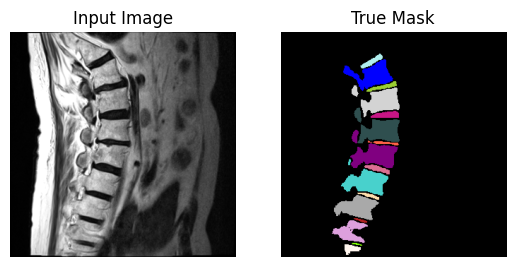

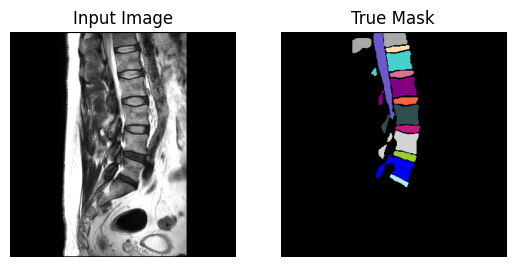

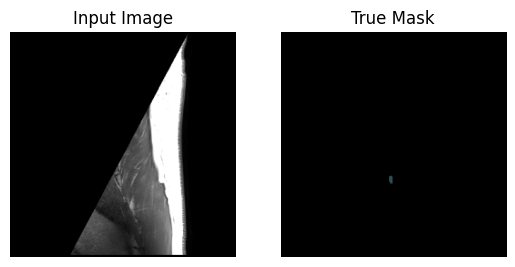

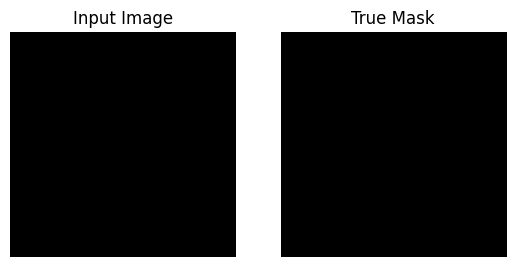

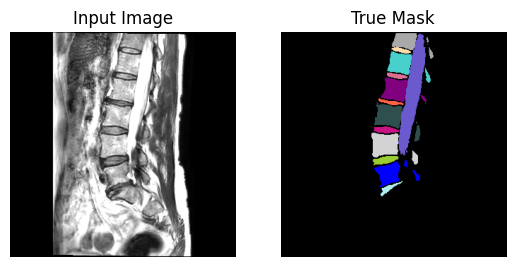

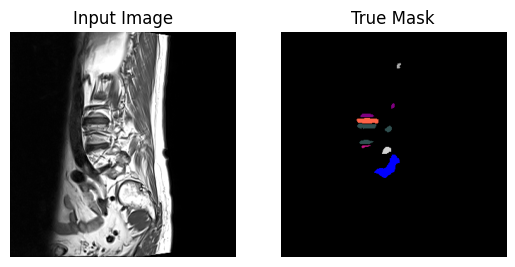

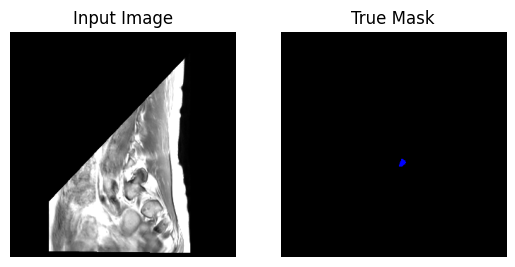

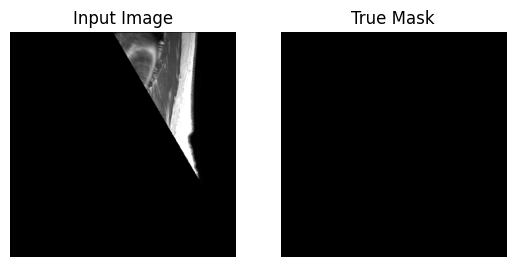

In [7]:
for image, mask, weights in train_ds.take(1):
    for i in range(image.shape[0]):
        display([image[i], mask[i]])

In [8]:
test_images, test_masks = next(iter(resized_val_ds))

class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            pred_masks = model.predict(test_images)

            # Randomly select an image from the test batch
            random_index = random.randint(0, BATCH_SIZE - 1)
            random_image = test_images[random_index]
            random_pred_mask = mask2rgb(pred_masks[random_index], is_one_hot=True)
            random_true_mask = mask2rgb(test_masks[random_index])

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
            ax[0].imshow(random_image)
            ax[0].set_title(f"Image")

            ax[1].imshow(random_true_mask)
            ax[1].set_title(f"Ground Truth Mask")

            ax[2].imshow(random_pred_mask)
            ax[2].set_title(f"Predicted Mask")

            plt.show()
            plt.close()


callbacks = [DisplayCallback(5)]

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, Conv2DTranspose, concatenate, ReLU, BatchNormalization


def conv_block(inputlay, base, batchnorm = False):
    
    layer = Conv2D(filters= base, kernel_size=(3,3), strides=(1,1), padding='same')(inputlay)
    if(batchnorm):
        layer = BatchNormalization()(layer)
    block = ReLU()(layer)
    
    layer = Conv2D(filters= base, kernel_size=(3,3), strides=(1,1), padding='same')(block)
    if(batchnorm):
        layer = BatchNormalization()(layer)
    block = ReLU()(layer)
    
    return block

def get_unet(img_ch, img_width, img_height, base, dropout = False, droprate = 0.2 ,batchnorm = False, mult_class = False, n_classes = 3):
    
    inputlay = Input(shape = (img_width, img_height, img_ch))
    
    conv1 = conv_block(inputlay, base, batchnorm)
    mp1 = MaxPooling2D(2, 2)(conv1)
    if(dropout):
        mp1 = Dropout(droprate)(mp1)
    
    conv2 = conv_block(mp1, base*2, batchnorm)
    mp2 = MaxPooling2D(2, 2)(conv2)
    if(dropout):
        mp2 = Dropout(droprate)(mp2)
    
    conv3 = conv_block(mp2, base*4, batchnorm)
    mp3 = MaxPooling2D(2, 2)(conv3)
    if(dropout):
        mp3 = Dropout(droprate)(mp3)
        
    conv4 = conv_block(mp3, base*8, batchnorm)
    mp4 = MaxPooling2D(2, 2)(conv4)
    if(dropout):
        mp4 = Dropout(droprate)(mp4)
    
    conv5 = conv_block(mp4, base*16, batchnorm)
    
    ct1 = Conv2DTranspose(base*8, (2, 2), strides = (2, 2), padding = "same")(conv5)
    ct1 = concatenate([ct1, conv4])
    if(dropout):
        ct1 = Dropout(droprate)(ct1)
    ct1 = conv_block(ct1, base*8, batchnorm)
    
    ct2 = Conv2DTranspose(base*4, (2, 2), strides = (2, 2), padding = "same")(ct1)
    ct2 = concatenate([ct2, conv3])
    if(dropout):
        ct2 = Dropout(droprate)(ct2)
    ct2 = conv_block(ct2, base*4, batchnorm)
    
    ct3 = Conv2DTranspose(base*2, (2, 2), strides = (2, 2), padding = "same")(ct2)
    ct3 = concatenate([ct3, conv2])
    if(dropout):
        ct3 = Dropout(droprate)(ct3)
    ct3 = conv_block(ct3, base*2, batchnorm)
    
    ct4 = Conv2DTranspose(base, (2, 2), strides = (2, 2), padding = "same")(ct3)
    ct4 = concatenate([ct4, conv1])
    if(dropout):
        ct4 = Dropout(droprate)(ct4)
    ct4 = conv_block(ct4, base, batchnorm)

    if not mult_class:
        out = Conv2D(1, (1, 1), activation = "sigmoid")(ct4)
    else:
        out = Conv2D(n_classes, (1, 1), activation = "softmax", padding = "same")(ct4)
    
    cur_shape = out.shape
    out = tf.reshape(out, [-1, cur_shape[1] * cur_shape[2], cur_shape[3]])
    
    model = Model(inputs = inputlay, outputs = out)
    model.summary()
    return model

In [ ]:
model = get_unet(1, IMAGE_SIZE, IMAGE_SIZE, 32, dropout=True, droprate=0.15, batchnorm=True, mult_class=True, n_classes=OUT_CLASSES)

model.compile(
    optimizer=keras.optimizers.Adam(LR),
    loss="sparse_categorical_crossentropy",
    #loss="categorical_crossentropy",
    metrics=["accuracy"],
    sample_weight_mode="temporal",
)

# Train the model, doing validation at the end of each epoch.
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
    #class_weight=dict(enumerate(class_weights)),
)

model.save('/kaggle/working/model.keras')

In [11]:
model = tf.keras.models.load_model('/kaggle/working/model.keras')

1/1 [==============================] - 0s 414ms/step


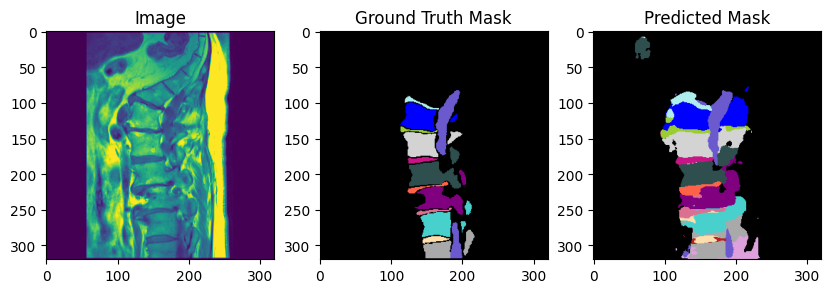

1/1 [==============================] - 0s 32ms/step


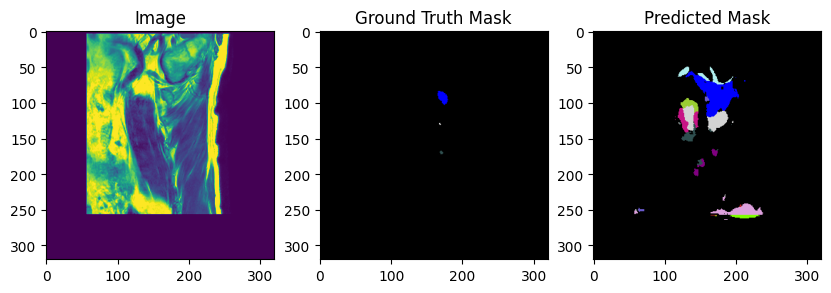

1/1 [==============================] - 0s 22ms/step


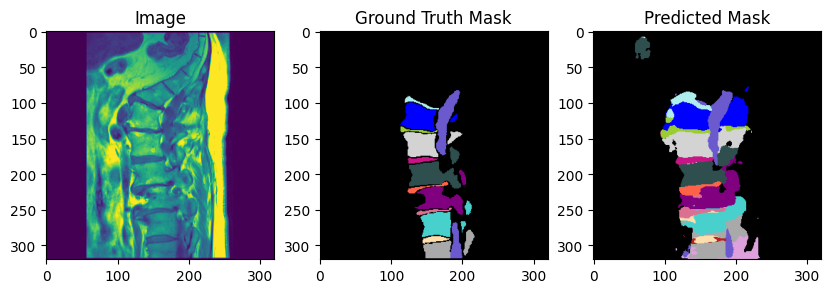

1/1 [==============================] - 0s 21ms/step


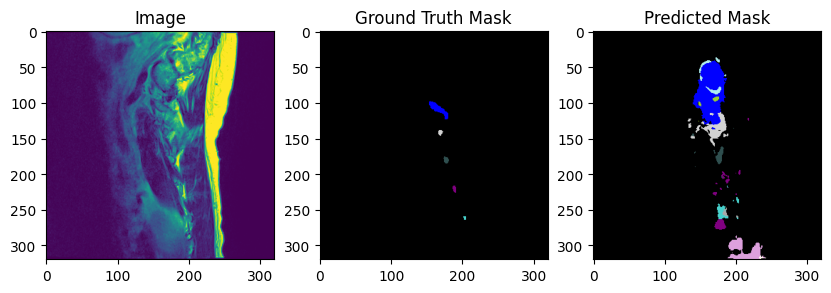

1/1 [==============================] - 0s 23ms/step


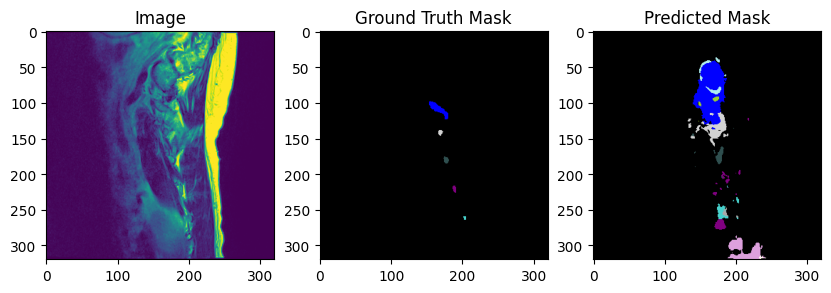

1/1 [==============================] - 0s 23ms/step


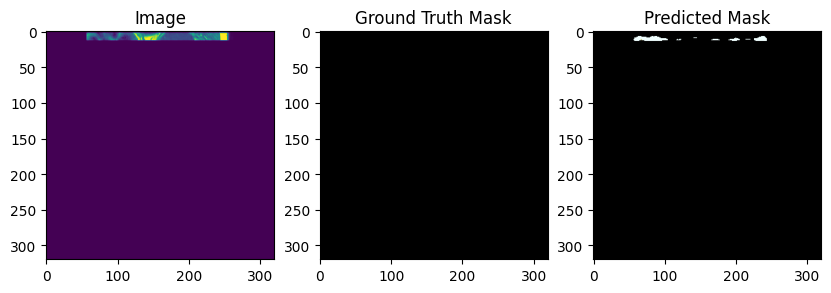

1/1 [==============================] - 0s 22ms/step


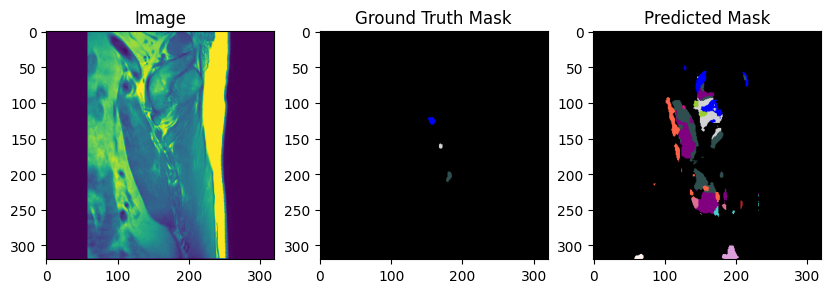

1/1 [==============================] - 0s 22ms/step


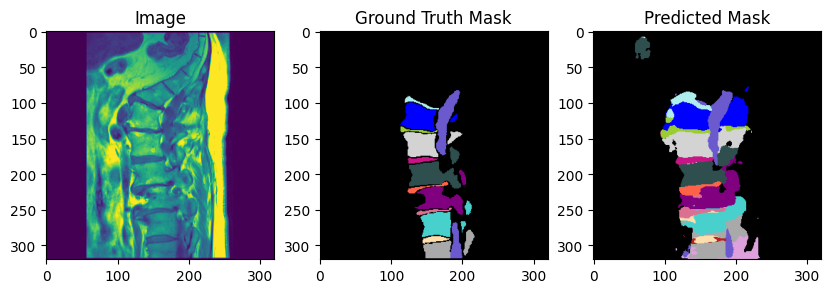

1/1 [==============================] - 0s 23ms/step


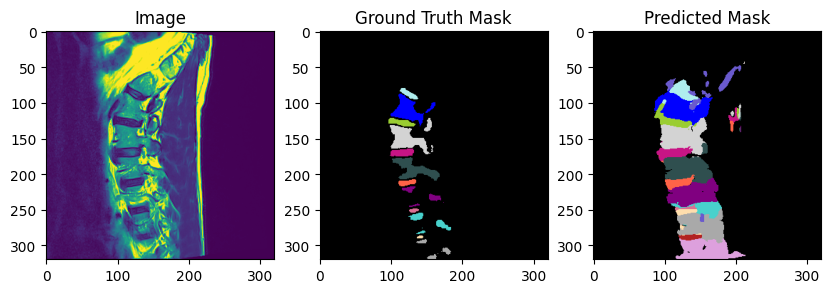

1/1 [==============================] - 0s 23ms/step


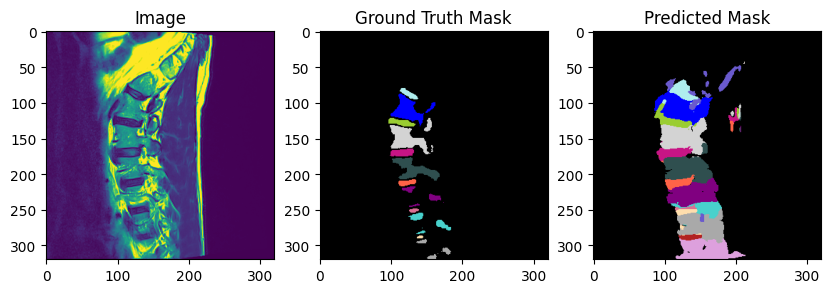

In [12]:
def test_model():
    pred_masks = model.predict(test_images)

    # Randomly select an image from the test batch
    random_index = random.randint(0, BATCH_SIZE - 1)
    random_image = test_images[random_index]
    random_pred_mask = mask2rgb(pred_masks[random_index], is_one_hot=True)
    random_true_mask = mask2rgb(test_masks[random_index])

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    ax[0].imshow(random_image)
    ax[0].set_title(f"Image")

    ax[1].imshow(random_true_mask)
    ax[1].set_title(f"Ground Truth Mask")

    ax[2].imshow(random_pred_mask)
    ax[2].set_title(f"Predicted Mask")

    plt.show()
    plt.close()
    
for i in range(10):
    test_model()